In [57]:
import pandas as pd
import numpy as np 
import scipy.optimize as sco 
import matplotlib.pyplot as plt 
%matplotlib inline
from finrl.marketdata.yahoodownloader import YahooDownloader
import portfolio_stats as ps 
import random
import plotly.express as px 
import six
import scipy.cluster.hierarchy as sch
import cvxopt as opt
from cvxopt import blas, solvers
from pandas.tseries.offsets import BDay

import importlib
importlib.reload(ps)

import pypfopt

In [7]:
%%capture
#get historical price and returns for SPY, QQQ and DOW 
price, daily_rts = ps.get_price(['SPY','QQQ','DOW','USO','USIG'],'2005-01-01','2022-01-01')
price, daily_rts =price.resample('B').first(), daily_rts.resample('B').first()

# Random simulation

In [8]:
def random_weights_generator(returns): 
    random_weights = pd.DataFrame( columns = returns.columns, index = returns.index)
    n_assets = len(returns.columns)
    #dirichlet distribution generate n numbers that adds up to certain number
    weights = list(((np.random.dirichlet(np.ones(n_assets),size=1))).flatten())
    for idx, i  in enumerate(list(returns.columns)): 
        random_weights[i] = weights[idx]
    return random_weights

In [9]:
#randomly generate a set of weights for the portfolio
rand_weights1 = random_weights_generator(daily_rts)
rand_weights1.head()

tic,DOW,QQQ,SPY,USIG,USO
date,,,,,
2019-03-21,0.03749,0.115101,0.103175,0.127657,0.616578
2019-03-22,0.03749,0.115101,0.103175,0.127657,0.616578
2019-03-25,0.03749,0.115101,0.103175,0.127657,0.616578
2019-03-26,0.03749,0.115101,0.103175,0.127657,0.616578
2019-03-27,0.03749,0.115101,0.103175,0.127657,0.616578


In [11]:
#calculate portfolio risk and return given weights
p1 = ps.Portfolio(daily_rts, rand_weights1, 0.02)
p1_sigma = p1.portfolio_sigma()
p1_meanreturns = p1.portfolio_mean_returns()
print('Annualized portfolio sigma and mean returns ')
print(p1_sigma,p1_meanreturns)

Annualized portfolio sigma and mean returns 
0.3442940617730669 0.015689028259440085


In [13]:
#start a dataframe to record simulated portfolio sigma and returns
n_simulations = 1000 
simulated_portfolio = pd.DataFrame(columns = ['sigma','mean_returns','sharpe'], index = [i for i in range(0,n_simulations)])
for i in range(0, n_simulations ): 
    rand_weights1 = random_weights_generator(daily_rts)
    p1 = ps.Portfolio(daily_rts, rand_weights1, 0.02)
    simulated_portfolio.iloc[i]  = [p1.portfolio_sigma(),  p1.portfolio_mean_returns(), p1.portfolio_sharpe()] 


In [14]:
# simulated_portfolio.set_index('sigma').iplot(kind ='scatter',mode='markers', title = 'Simulated portfolio', 
# yTitle  = 'mean returns', xTitle = 'risk(sigma)')

fig = px.scatter(simulated_portfolio, x = 'sigma', y = 'mean_returns', hover_data= ['sharpe'], title = 'Simulated portfolio' )
fig.show( )

# Modern Portfolio Theory
- From the above graph, given a certain level of risk, there is an optimal(max) returns on the frontier of the graph -- this is the efficient frontier.
- The goal is to minimize portfolio risk(portfolio variance) while maximizing sharpe value
- Here we use scipy optimizaer as our tool

Scipy optimizer 
- type: can be eq or ineq, refers to equality or inequality respectively. Eq means we are looking for our function to be 0
- fun: refers to the function defining the constraint, here the constraint is the sum of the stock weights must be 1
- bounds: specify each stock weight must between 0-1
- args: the argument we want to pass to the function we are trying to minimize, so every argument except the weights
So the simplest way to achieve this is to create a lambda function that returns the sum of portfolio weights - 1


In [17]:
#define the objective function for scipy minimize-- here is the negative sharpe function
def neg_sharpe_ratio(weights,returns, risk_free_rate):
    p1 = ps.Portfolio(returns, weights, risk_free_rate)
    return (-1)*p1.portfolio_sharpe()

def neg_total_returns(weights,returns, risk_free_rate):
    p1 = ps.Portfolio(returns, weights, risk_free_rate)
    return (-1)*p1.portfolio_total_returns()

def neg_mean_returns(weights,returns, risk_free_rate):
    p1 = ps.Portfolio(returns, weights, risk_free_rate)
    return (-1)*p1.portfolio_mean_returns()

def _sigma(weights,returns, risk_free_rate):
    p1 = ps.Portfolio(returns, weights, risk_free_rate)
    return p1.portfolio_sigma()

In [18]:

def mpt_static_weights_generator(returns, rf, objective_function):
    """This funtion calculats static optimal weights according to modern porfolio
    theory using scipy optimize
    returns: a dataframe of daily returns
    rf: scalar value of risk free rate
    returns: a df of optimized weights based on MPT
    objective_function: str: 'max_sharpe', 'min_volatility', 
    'max_total_returns', 'max_mean_returns' """
    n_assets = len(returns.columns)
    args = (returns, rf)
    bounds = tuple((0,1) for asset in range(n_assets))
    if objective_function == 'max_sharpe': 
        result = sco.minimize(  neg_sharpe_ratio,
                        #initialize random weights for your portfolio
                        n_assets*[1./n_assets,], 
                        #args are a tuple of varaibles in your objective function that are given
                        args=args,
                        method='SLSQP', 
                        # another limit/bound to assign random weights
                        bounds=bounds, 
                        #constraint -- sum of x == 1(sum of all weights add up to 1)
                        constraints=({'type':'eq',
                        'fun':lambda x: np.sum (x)-1}))
    
    if  objective_function == 'min_volatility': 
        result = sco.minimize(  _sigma ,n_assets*[1./n_assets,], args=args, method='SLSQP', bounds=bounds, constraints=({'type':'eq','fun':lambda x: np.sum (x)-1}))
    
    if  objective_function == 'max_total_returns': 
        result = sco.minimize(  neg_total_returns ,n_assets*[1./n_assets,], args=args, method='SLSQP', bounds=bounds, constraints=({'type':'eq','fun':lambda x: np.sum (x)-1}))
    
    if  objective_function == 'max_mean_returns': 
        result = sco.minimize(  _sigma ,n_assets*[1./n_assets,], args=args, method='SLSQP', bounds=bounds, constraints=({'type':'eq','fun':lambda x: np.sum (x)-1}))

    final_weights = round(pd.DataFrame(result['x'], index = daily_rts.columns, columns = [daily_rts.index[0]] ) .T,2)
    final_weights = final_weights.reindex(daily_rts.index).fillna(method = 'ffill')

    return final_weights

optimal_weights = mpt_static_weights_generator(daily_rts, 0.02,'max_mean_returns')
optimal_weights

tic,DOW,QQQ,SPY,USIG,USO
date,,,,,
2019-03-21,0.0,0.0,0.03,0.95,0.01
2019-03-22,0.0,0.0,0.03,0.95,0.01
2019-03-25,0.0,0.0,0.03,0.95,0.01
2019-03-26,0.0,0.0,0.03,0.95,0.01
2019-03-27,0.0,0.0,0.03,0.95,0.01
...,...,...,...,...,...
2021-10-01,0.0,0.0,0.03,0.95,0.01
2021-10-04,0.0,0.0,0.03,0.95,0.01
2021-10-05,0.0,0.0,0.03,0.95,0.01


In [19]:
p0 = ps.Portfolio(daily_rts, optimal_weights, 0.02)
simulated_portfolio['if_optimal'] = 0
simulated_portfolio.iloc[-1]  = [p0.portfolio_sigma(),  p0.portfolio_mean_returns(),p0.portfolio_sharpe(),  1 ] 


In [20]:

fig = px.scatter(simulated_portfolio, x = 'sigma', y = 'mean_returns', color = 'if_optimal',
 hover_data = ['sharpe'], title ='Simulated portfolio with optimal sharpe' )
fig.show( )

In [21]:
# althertiave to generate MPT weights using pyportfolioopt lib
mpt_weights = pypfopt.efficient_frontier.EfficientFrontier(expected_returns =(daily_rts.mean())*260,
cov_matrix = daily_rts.cov() )

pd.DataFrame(mpt_weights.min_volatility(), index = [0]).apply(lambda x: round(x,5))

,DOW,QQQ,SPY,USIG,USO
0,0.0,0.0,0.03328,0.95395,0.01277


# Hierachical risk parity
On a high level
- why does MPT fail? high correlation among assets leads to instability of optimization problems.
- From your universe of assets, form a distance matrix based on asset correlation 
- Using the distance matrix, cluster assets into a tree via hierarchical clustering
- Within each branch of the tree, form the minimum variance portfolio(normally between just 2 assets)
- Iterate over each level, optimally combining the mini-portfolio at each node
- reference : https://hudsonthames.org/an-introduction-to-the-hierarchical-risk-parity-algorithm/ 
- see appendix for detailed notes

In [22]:

def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp


def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar


def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()


def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w


def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist = ((1 - corr) / 2.)**.5  # distance matrix
    return dist


def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    dist = correlDist(corr)
    link = sch.linkage(dist, 'single')
    #dn = sch.dendrogram(link, labels=cov.index.values, label_rotation=90)
    #plt.show()
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx).sort_index()
    #hrp = pd.DataFrame(dict(hrp), index = daily_rts.index)
    return hrp 


In [23]:
cov, corr = daily_rts.cov(), daily_rts.corr()
hrpw = getHRP(cov, corr)


In [24]:
a = pypfopt.HRPOpt(returns = daily_rts).optimize()
pd.DataFrame(a, index = daily_rts.index)

,DOW,QQQ,SPY,USIG,USO
date,,,,,
2019-03-21,0.024626,0.040294,0.050925,0.856959,0.027196
2019-03-22,0.024626,0.040294,0.050925,0.856959,0.027196
2019-03-25,0.024626,0.040294,0.050925,0.856959,0.027196
2019-03-26,0.024626,0.040294,0.050925,0.856959,0.027196
2019-03-27,0.024626,0.040294,0.050925,0.856959,0.027196
...,...,...,...,...,...
2021-10-01,0.024626,0.040294,0.050925,0.856959,0.027196
2021-10-04,0.024626,0.040294,0.050925,0.856959,0.027196
2021-10-05,0.024626,0.040294,0.050925,0.856959,0.027196


# Performance comparison
## Static weights

In [27]:
# generate different optimized weights
weights = {}
optimizer = ps.portfolio_optimizer(daily_rts, 0.02)
weights['random'] = optimizer.random_weights()
weights['mpt_maxsharpe'] = optimizer.mpt_weights('max_sharpe')
weights['mpt_minvol'] = optimizer.mpt_weights('min_volatility')
weights['mpt_maxtotalreturns'] = optimizer.mpt_weights('max_total_returns')
weights['mpt_maxmeanreturns'] = optimizer.mpt_weights('max_mean_returns')
weights['hrp'] = optimizer.hrp_weights()



In [36]:
static_df = pd.DataFrame()
for i in weights.keys(): 
    static_df[i]= ps.Portfolio( daily_rts,weights[i], 0.02).portfolio_cum_returns()['portfolio_cum_returns']
static_df.iplot(title='Returns comparison')

## Dynamic weights
- Previously, the optimized weights are based on existing historical price, but here we invent the concept of dynamic weights where weights are optimized on certain period (training window), and will be allocated on a certain period(allocation window)
- Assign weights using modern portfolio theory and hierarchical risk parity given training window and allocation window

In [37]:

weights['mpt-7-7-sharpe'] = optimizer.mpt_weights_dynamic(7,7,'max_sharpe')
weights['mpt-7-7-ttlrts'] = optimizer.mpt_weights_dynamic(7,7,'max_total_returns')
weights['mpt-7-7-vols'] = optimizer.mpt_weights_dynamic(7,7,'min_volatility')
weights['mpt-260-260-sharpe'] = optimizer.mpt_weights_dynamic(260,260,'max_sharpe')
weights['mpt-260-260-ttlrts'] = optimizer.mpt_weights_dynamic(260,260,'max_total_returns')
weights['mpt-260-260-vols'] = optimizer.mpt_weights_dynamic(260,260,'min_volatility')
weights['hrp-7-7'] = optimizer.hrp_weights_dynamic(7,7)
weights['hrp-260-260'] = optimizer.hrp_weights_dynamic(260,260)


In [41]:
# plot performance from weights dic 
cum_rts = { }
for i in weights.keys(): 
    cum_rts [i] = ps.Portfolio(daily_rts, weights[i], 0.02).portfolio_cum_returns().resample('B').last()
    cum_rts[i].columns = [i]

cum_rtsdf = pd.concat(cum_rts, axis = 1).dropna()
cum_rtsdf.columns =  list(cum_rts.keys()) 
cum_rtsdf.iplot(title = ','.join(daily_rts.columns))

# Search for best window

In [58]:
%%capture
importlib.reload(ps)
assets = [ ['SPY','QQQ','USO'],['QQQ','USIG'],['SPY','QQQ','DOW','GLD','USO','USIG'],['SPY','VGK','EEM','AAXJ'],['SPY','QQQ','DOW']]

windows =[[260,260],[7,7], [7,360],[360,7]]

#search for MPT max sharpe weights
search_engine = ps.search_allocation(assets, windows)
weights1 = search_engine.generate_weights('MPT','max_sharpe')
#search for MPT total returns weights
weights2 = search_engine.generate_weights('MPT','max_total_returns')
#search for HRP
weights3 = search_engine.generate_weights('HRP')
#merge three dictionaries together
weights = {**weights1, **weights2, **weights3}
portfolios = search_engine.generate_portfolios(weights)
portfoliosummary =search_engine.generate_portfolio_summary( )
#search_engine.get_price_batch()
# search_engine.generate_weights('MPT','max_sharpe')



In [59]:
portfoliosummary

,total_returns,mean_returns,sigma,sharpe,assets,opt_method,obj_fun,train_w,allo_w
0,-0.041618,0.039828,0.326118,0.060801,SPY-QQQ-DOW,MPT,max_sharpe,7,7
0,0.019595,0.017529,0.149086,-0.016572,SPY-QQQ-DOW-GLD-USO-USIG,MPT,max_total_returns,260,260
0,0.036492,0.052199,0.277802,0.115905,SPY-QQQ-USO,HRP,NaN,7,360
0,0.051058,0.019604,0.039624,-0.009998,QQQ-USIG,HRP,NaN,360,7
0,0.057138,0.022006,0.044874,0.044700,SPY-QQQ-DOW-GLD-USO-USIG,HRP,NaN,360,7
0,0.072747,0.031044,0.094480,0.116889,SPY-QQQ-DOW-GLD-USO-USIG,MPT,max_sharpe,360,7
0,0.180570,0.055848,0.049282,0.727402,QQQ-USIG,HRP,NaN,260,260
0,0.186915,0.107041,0.300919,0.289252,SPY-QQQ-DOW-GLD-USO-USIG,MPT,max_total_returns,7,7
0,0.187578,0.062705,0.110495,0.386492,SPY-QQQ-DOW-GLD-USO-USIG,MPT,max_sharpe,260,260
0,0.196518,0.083479,0.193251,0.328478,QQQ-USIG,MPT,max_sharpe,7,7


# Appendix
## HRP implementation code

In [99]:
%%capture
#get historical price and returns for SPY, QQQ and DOW 
price, daily_rts = ps.get_price(['SPY','QQQ','DOW','USO','GLD','USIG','AMD','PDD'],'2005-01-01','2022-01-01')
price, daily_rts =price.resample('B').first(), daily_rts.resample('B').first()

<ipython-input-96-5c094bc88b0e>:16: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



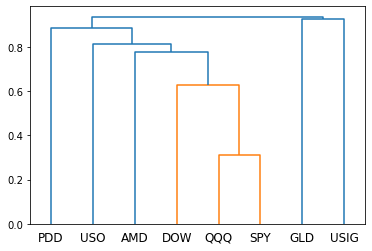

PDD     0.005627
USO     0.021168
AMD     0.007341
DOW     0.011743
QQQ     0.051803
SPY     0.061953
GLD     0.122571
USIG    0.717794
dtype: float64

In [96]:

returns  = daily_rts
cov, corr = returns.cov(), returns.corr()
"""distance matrix based on correlation
this distance metric allows us to measure the distances between 
two column vectors
"""
dist = ((1-corr)/2) **(0.5)
"""perform hierarchical clustering, method='single',
returns the hierarchical clustering encoded as a linkage matrix,
link is (n-1) by 4 matrix Z returned, 
say Z[0] = [1, 2, 1.431223, 2] 
the first two value tells us which clusters were used to create cluster 0,
which are cluster 1 and cluster 2,
the third value gives us distance between two clusters,
the fourth value is the number of original observations in the newly formed cluster"""
link = sch.linkage(dist, 'single')
dn = sch.dendrogram(link, labels=cov.index.values)
plt.show()

"""matrix seriation -- quasi-diagonalisation,
return the sequence of dendrogram
rearrange the data to show the inherent clusters clearly,
so similar investment are placed together 
and dissimilar investment are placed far apart
- link cluster label is in cov.index.values
- link matrix combines to closest data points first
"""
link = link.astype(int)
sortIx = pd.Series([link[-1, 0], link[-1, 1]])
numItems = link[-1, 3]  # number of original items
while sortIx.max() >= numItems:
    sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
    df0 = sortIx[sortIx >= numItems]  # find clusters
    i = df0.index
    j = df0.values - numItems
    sortIx[i] = link[j, 0]  # item 1
    df0 = pd.Series(link[j, 1], index=i + 1)
    sortIx = sortIx.append(df0)  # item 2
    sortIx = sortIx.sort_index()  # re-sort
    sortIx.index = range(sortIx.shape[0])  # re-index
sortIx= sortIx.tolist()
sortIx = corr.index[sortIx].tolist()


w = pd.Series(1, index=sortIx)
cItems = [sortIx]  # initialize all items in one cluster
while len(cItems) > 0:
    
    # print(cItems)
    # separate each items in cItems list into two binary groups
    cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2),
     (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
    for i in range(0, len(cItems), 2):  # parse in pairs
        
        # assign inverse-variance portfolio weighting
        """inverse variance weighting is a method of aggregating two of more 
        random variables to minimize the variance of the weighted average,
        each variable is weights in inverse portion of its variane"""
        cItems0 = cItems[i]  # cluster 1
        cItems1 = cItems[i + 1]  # cluster 2
        cVar0 = getClusterVar(cov, cItems0)
        cVar1 = getClusterVar(cov, cItems1)
        alpha = 1 - cVar0 / (cVar0 + cVar1)
        w[cItems0] *= alpha  # weight 1
        w[cItems1] *= 1 - alpha  # weight 2
        # print('***')
        # print(cItems0, cItems1)
        # print(w)
w